In [54]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.transform import from_origin
from mikeio import Dfs2
from mikeio.eum import ItemInfo, EUMType

## From geoTIFF to Dfs2

In [3]:
fn = 'gebco_2020_n57.5_s55.0_w10.0_e13.0.tif'

In [4]:
ds = rio.open(fn)

In [30]:
ds.bounds

BoundingBox(left=9.999999999999998, bottom=55.0, right=13.000000000000002, top=57.5)

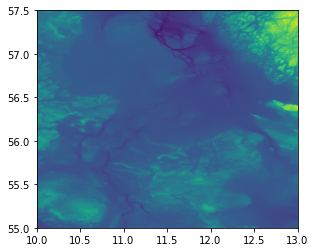

<AxesSubplot:>

In [9]:
show(ds)

### Create Dfs2

In [24]:
dfs = Dfs2()

In [25]:
dat = ds.read(1)
dat.shape

(600, 720)

In [26]:
dat = dat.astype('float32')
dat[dat > 0.0] = np.nan              # make land delete values
dat = np.expand_dims(dat, axis=0)    # must have time axis

In [27]:
nx = ds.width
ny = ds.height
x0 = ds.bounds.left
y0 = ds.bounds.bottom
dx = (ds.bounds.right - ds.bounds.left)/(nx - 1)
dy = (ds.bounds.top - ds.bounds.bottom)/(ny - 1)
coordinate = ['LONG/LAT', x0, y0, 0]

In [29]:
fn2 = 'gebco_2020_n57.5_s55.0_w10.0_e13.0.dfs2'
items = [ItemInfo("Elevation", EUMType.Total_Water_Depth)]
dfs.write(fn2,[dat],coordinate=coordinate, dx=dx, dy=dy, items=items)

C:\Users\JEM\Anaconda3\lib\site-packages\mikeio\dfs.py:223: UserWarning: No start time supplied. Using current time: 2021-03-15 16:49:48.993733 as start time.
  warnings.warn(
C:\Users\JEM\Anaconda3\lib\site-packages\mikeio\dfs.py:236: UserWarning: No timestep supplied. Using 1s.
  warnings.warn("No timestep supplied. Using 1s.")


## From Dfs2 to geoTIFF

In [55]:
dfs = Dfs2('gebco_sound.dfs2')

In [56]:
datgrid = dfs.read()[0][0,:,:]

In [57]:
datgrid.shape

(264, 216)

In [58]:
proj = dfs._dfs.FileInfo.Projection

In [59]:
nx = dfs.shape[1]
ny = dfs.shape[2]

In [60]:
fn3 = 'gebco_sound_output.tif'
with rio.open(
     fn3,
     'w',
     driver='GTiff',
     height=ny,
     width=nx,
     count=1,
     dtype=datgrid.dtype,
     crs='+proj=latlong',
     transform=from_origin(proj.Longitude, proj.Latitude, dfs.dx, dfs.dy)
     ) as dst:
        dst.write(np.flipud(datgrid), 1)